In [1]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import lmfit as lm
from tqdm import tqdm
from contextlib import redirect_stdout
import io


import matplotlib.pyplot as plt
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
import sys, importlib

import sys
sys.path.append('./XPCSlibrary/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorrelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

### EXPERIMENTAL VARIABLES ###
XPCS.set_expvar(Nx//2, Ny//2, 5)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

from folder_paths import *

## Load masks

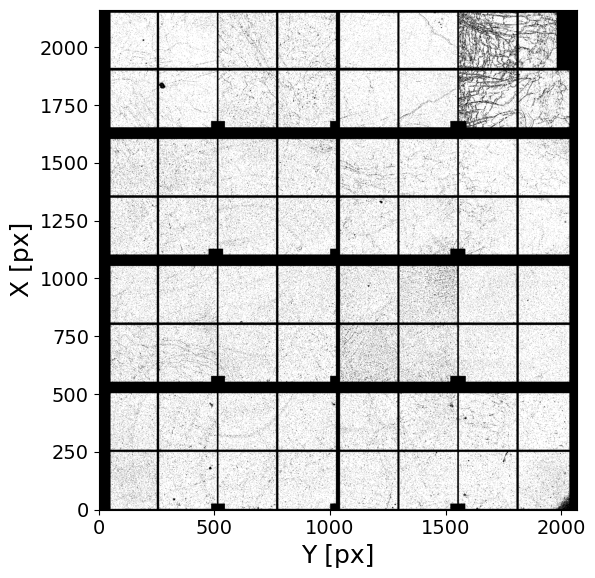

In [2]:
e4m_mask = np.load(MASKS_folder+'e4m_mask'+'.npy')
e4m_htmask = np.load(MASKS_folder+'e4m_htmask_Mo_fluorescence'+'.npy')

plt.figure(figsize=(6, 6))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

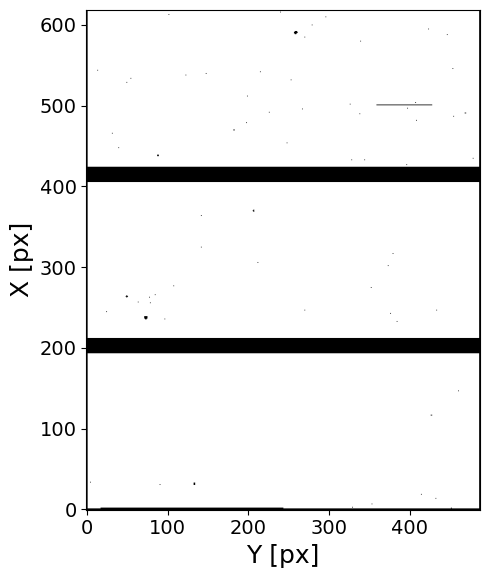

In [3]:
pilatus_mask = np.load(MASKS_folder+'pilatus300k_mask_20240201'+'.npy').astype(bool)

plt.figure(figsize=(6, 6))
plt.imshow(~pilatus_mask, cmap='gray', origin='lower')
plt.xlabel('Y [px]')
plt.ylabel('X [px]')
plt.tight_layout(); plt.show()

## Q mask

In [4]:
###########
Q = 0.57
dq = 0.01
###########
Q=float(Q)

## XPCS scan: delcoup=3.5, T=4h (Ta2O5_2.5um_asdep, 4, 6)  

Tantala as deposited

#############################
command = mtimescan 0.001 1 16000128
Ei = 21.669991317784486
itime = 0.0011
T =  4.001339833333334 h
theta = 3.499999999999999
Qc = 0.67
#############################



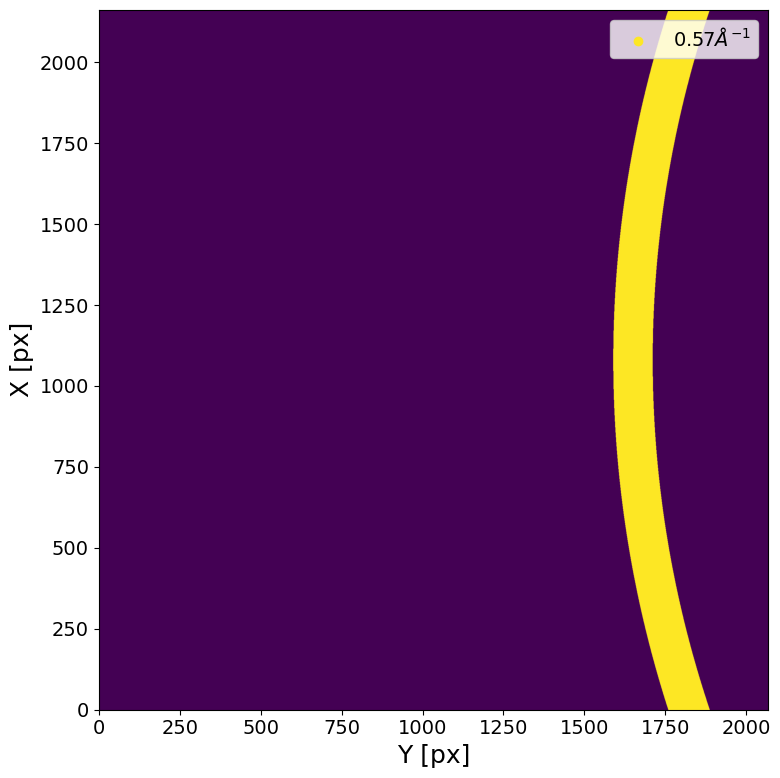

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/2618 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/2618 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00013.h5 (14/2618 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/2618 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/2618 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/2618 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00012.h5 (13/2618 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/2618 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/2618 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00050.h5 (51/2618 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00051.h5 (52/2618 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/2618 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/2618 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00052.h5 (53/2618 loops)
	 -> loading fil

In [14]:
#######################################
sample_name = 'Ta2O5_2.5um_asdep'
Ndataset = 4
Nscan = 6
#######################################

scan = ID10.load_scan(RAW_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
T = scan['fast_timer_period'].size*itime
theta = scan['delcoup']
Qc = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('T = ', T/60**2, 'h')
print('theta =', theta)
print('Qc =', Qc)
print('#############################\n')

#################################################################################
Nfi, Nff = None, len(scan['fast_timer_trig'])-5001
Qmask = XPCS.gen_Qmask(Ei, theta, Q, dq, Qmap_plot=False)
Kossel_mask = np.load(MASKS_folder+'Kossel_mask_Ta2O5_2.5um_asdep_0002_0001.npy')
load_mask = e4m_mask*e4m_htmask*Qmask#*Kossel_mask
##################################################################################

e4m_data = ID10.load_sparse_e4m(RAW_folder, sample_name, Ndataset, Nscan, Nfi=Nfi, Nff=Nff, load_mask=load_mask, n_jobs=50, )

### Flux check

################################################################################
Maximum count in the whole run -> 3.0
# of pixels above Ith_high treshold ->  4257881 pixels (of 4471016 => 95.23 %)
# of pixels below Ith_low treshold ->  213135 pixels (of 4471016 => 4.77 %)
################################################################################



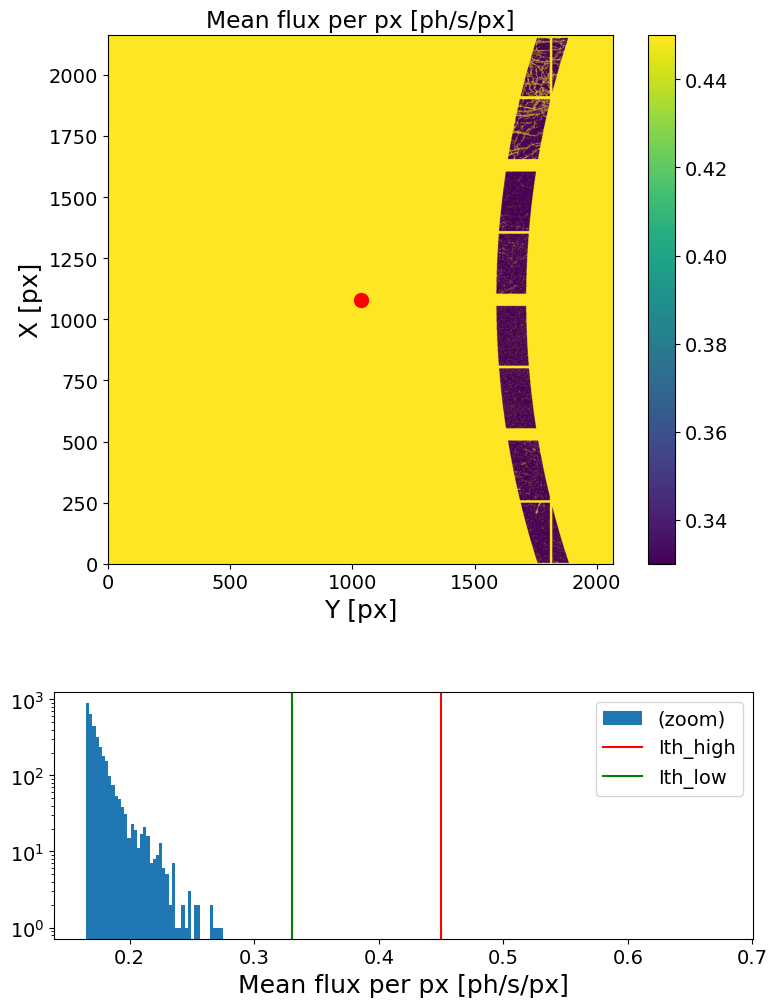

In [15]:
XPCS.gen_plots4mask(e4m_data, itime, Ith_low=.33, Ith_high=0.45, Nfi=None, Nff=int(1e7), load_mask=load_mask, mask=None)

### Intensity analysis

In [27]:
####################
Lbin = 500
Nstep = 1000
mask = None
Nfi = None
Nff = None
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep, Nfi=Nfi, Nff=Nff)
np.savez(It_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_It=t_It, It=It)

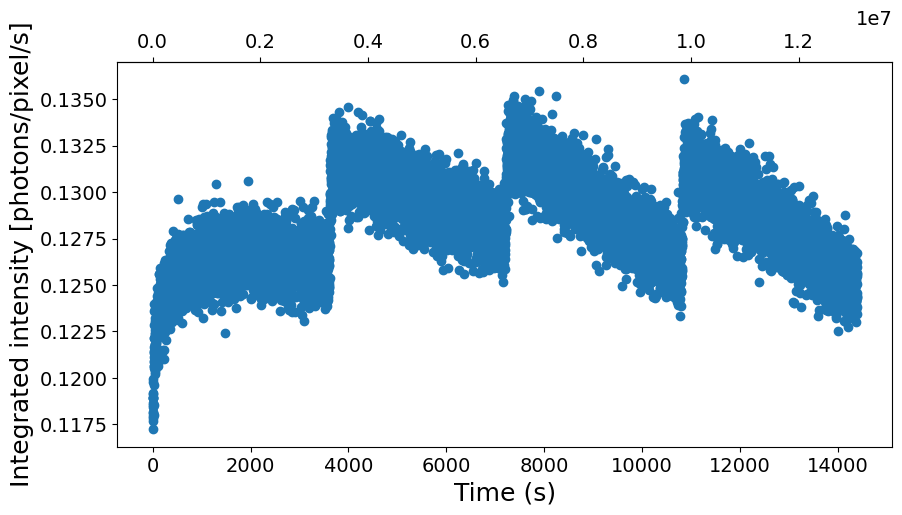

In [28]:
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
#plt.xscale('log')
plt.show()

### Linear correlation 4 tests

In [44]:
###################
Nfi = None
Nff = int(1e6)
Lbin = 1000
bin2dense = False
mask = None
###################
if Lbin is None: Lbin=1

G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

Loading frames ...
Done! (elapsed time = 0.11 s)
Binning frames (Lbin = 1000, using MKL library) ...
Done! (elapsed time = 0.1 s)
	 | 1000 frames X 213135 pixels
	 | sparsity = 1.28e-01
	 | memory usage (sparse.csr_array @ float32) = 0.305 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 1.54 s)
	 | 1000 X 1000 squared matrix
	 | memory usage (np.array @ float32) = 0.004 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.01 s)



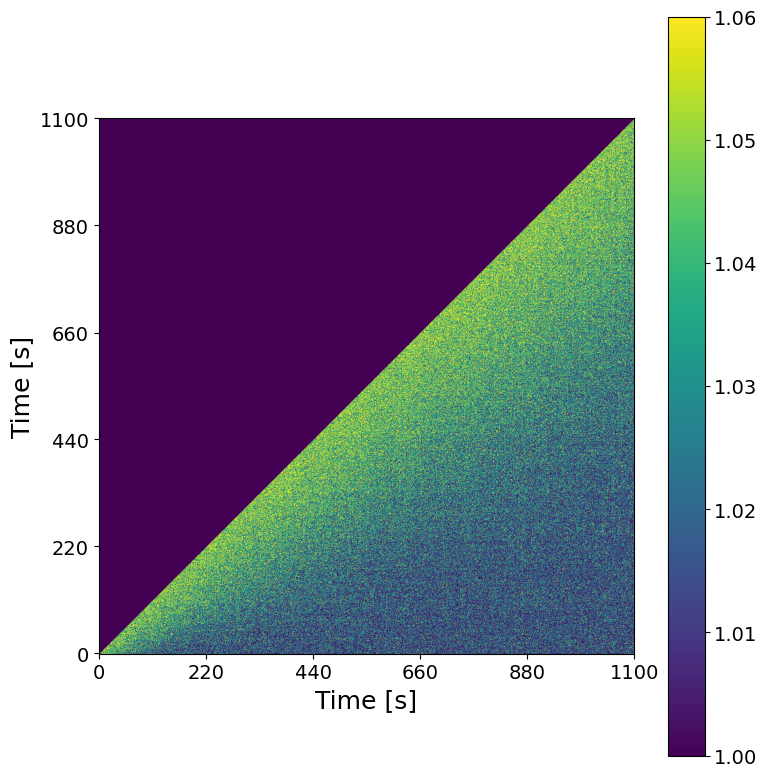

In [45]:
############################
t1, t2 = 0, 3000
vmin, vmax = 1.0, 1.06
############################
XPCS.plot_G2t(G2t, vmin, vmax, itime*Lbin, t1=t1, t2=t2, sigma_filter=None)

In [53]:
################
Nbunch = 4
################

NfXbunch = int(G2t.shape[0]/Nbunch)
t, g2, dg2, t_mt, g2_mt = {}, {}, {}, {}, {}
for n in range(Nbunch):
    if Nfi is None: Nfi = 0
    t_bunch = Nfi*itime + round(itime*Lbin*NfXbunch*(n+1/2),1)

    if Nbunch!=1: t[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t[NfXbunch*n:NfXbunch*(n+1), NfXbunch*n:NfXbunch*(n+1)]), cython=False)
    else:         t[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t), cython=False)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2mt_fromling2(itime*Lbin, g2[t_bunch])    


Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)

Computing g2 (using cython code)...
Done! (elapsed time = 0.0 s)



/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects w

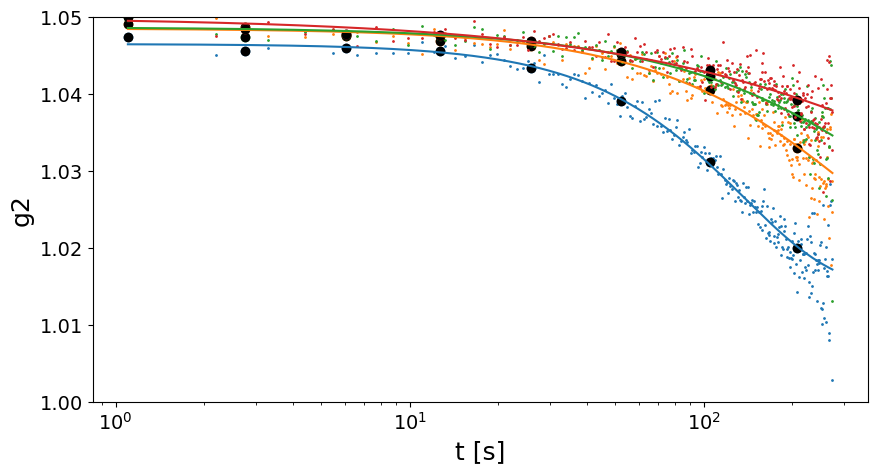

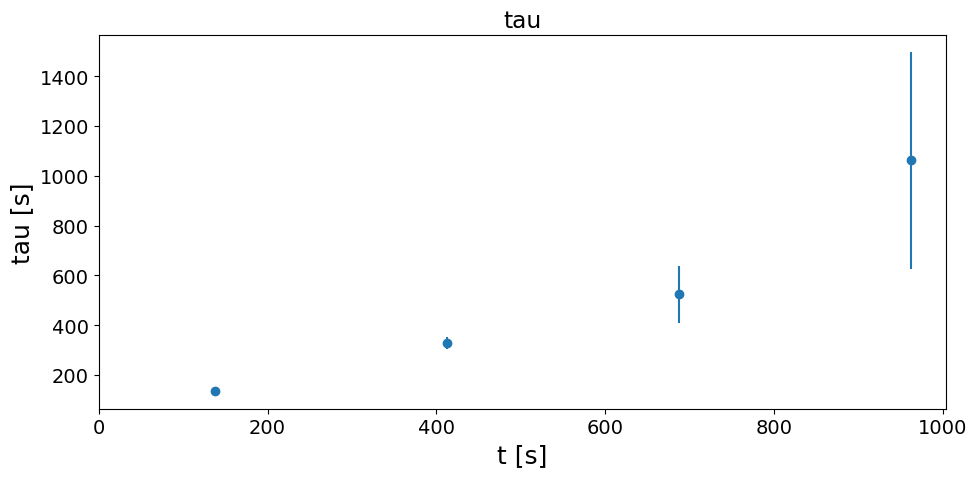

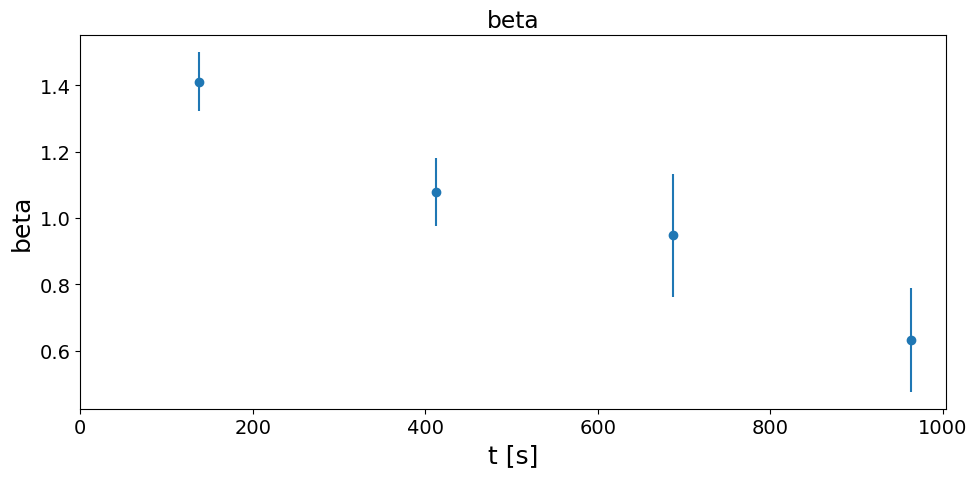

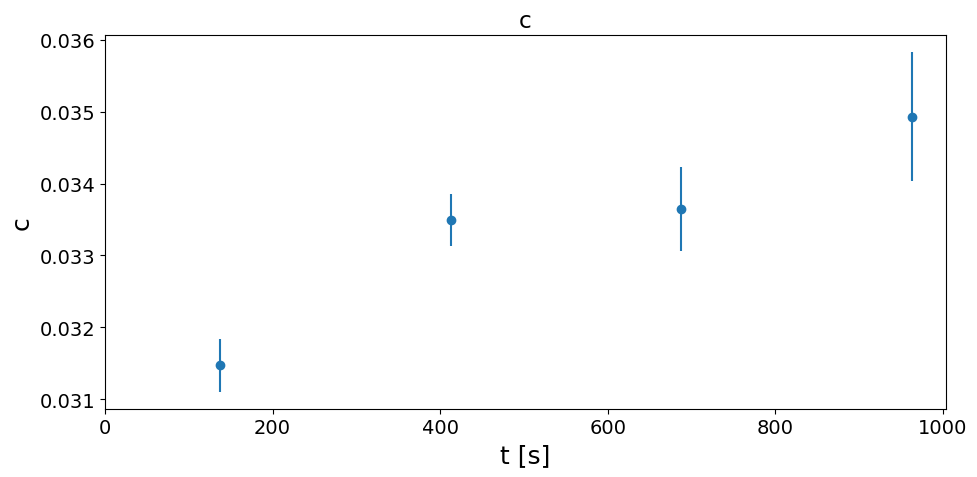

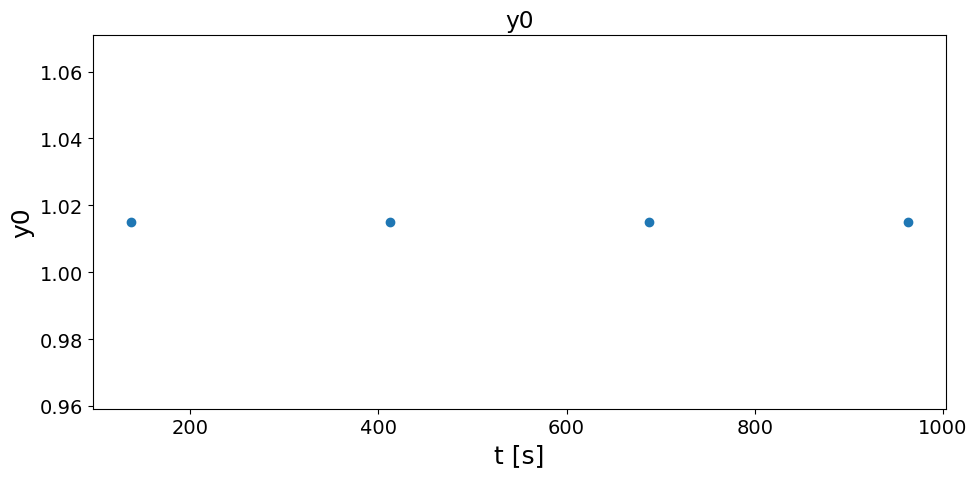

In [54]:
##################
t1_fit = 0
t2_fit = 1e100
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1.015, vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], c='C'+str(i), label=str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], c='black', label=str(k)+'s')

    x = t[k] [(t1_fit<t[k])*(t[k]<t2_fit)]
    y = g2[k][(t1_fit<t[k])*(t[k]<t2_fit)]
    x = t_mt[k] [(t1_fit<t_mt[k])*(t_mt[k]<t2_fit)]
    y = g2_mt[k][(t1_fit<t_mt[k])*(t_mt[k]<t2_fit)]
    fit = model.fit(y, params, t=x)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.05)
#plt.legend()
plt.show()

if Nbunch == 1:
    display(fit.params)
else:
    plt.figure(figsize=(10,5))
    plt.title('tau')
    plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('tau [s]')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('beta')
    plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('beta')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('c')
    plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('c')
    plt.xlim(0)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,5))
    plt.title('y0')
    plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
    plt.xlabel('t [s]')
    plt.ylabel('y0')
    plt.tight_layout(); plt.show()

### Linear by dose

In [18]:
t_ff = e4m_data.shape[0]*itime
print('#############################')
print('Nff =    =',e4m_data.shape[0], ' =>  t_ff =', t_ff)
print('#############################\n')

#############################
Nff =    = 13087327  =>  t_ff = 14396.059700000002
#############################



In [23]:
########################################
N_segments = 3
tt = np.linspace(0, int(t_ff), N_segments)
########################################

t_segments = [(tt[i], tt[i+1]) for i in range(len(tt)-1)]
Nf_segments =  [(int(t_segments[i][0]//itime), int(t_segments[i][1]//itime)) for i in range(len(t_segments))]

In [24]:
from contextlib import redirect_stdout
import io

###################
Lbin = 1000
bin2dense = False
mask = None
###################

t_g2, g2, dg2= {}, {}, {}
for i in tqdm(range(len(Nf_segments))):
    with redirect_stdout(io.StringIO()):
        Nfi = Nf_segments[i][0]
        Nff = Nf_segments[i][1]
        G2t = XPCS.get_G2t(e4m_data, mask=mask, Nfi=Nfi, Nff=Nff, Lbin=Lbin, bin2dense=bin2dense)

        t_bunch = Nfi*itime + (Nff-Nfi)/2*itime
        t_g2[t_bunch], g2[t_bunch], dg2[t_bunch] = XPCS.get_g2(itime*Lbin, np.array(G2t), cython=False)
np.savez(g2_folder+'g2_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq), t_g2=t_g2, g2=g2)

100%|██████████| 2/2 [00:40<00:00, 20.44s/it]


/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


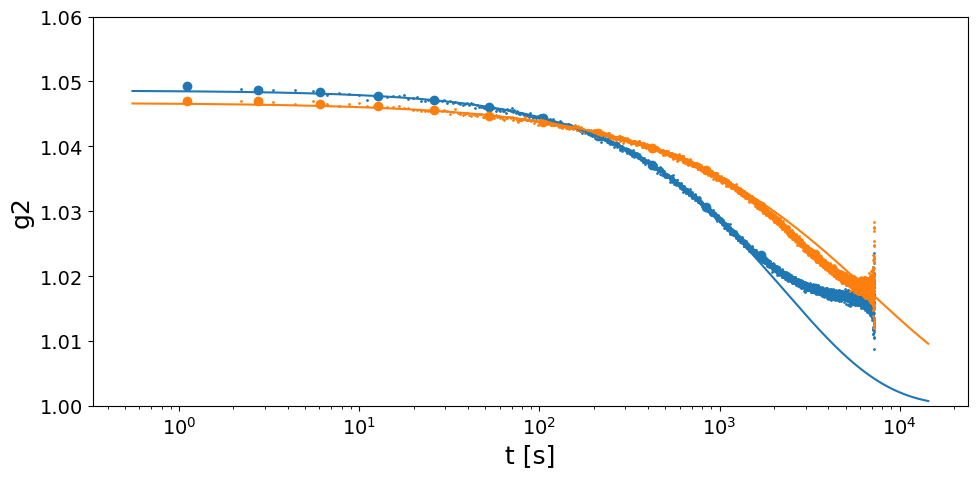

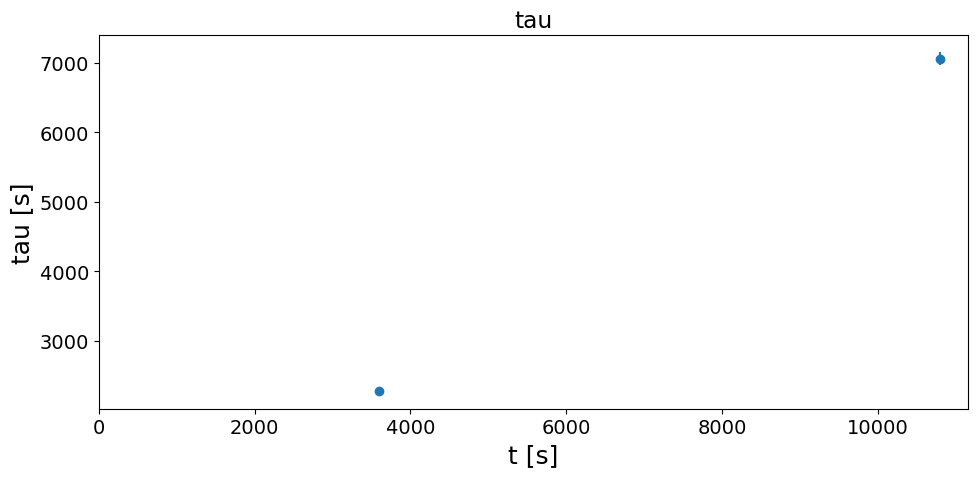

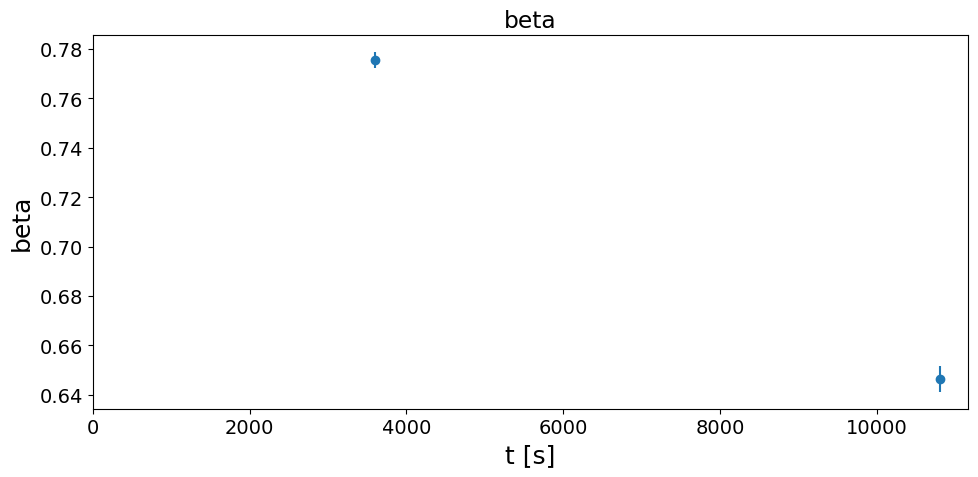

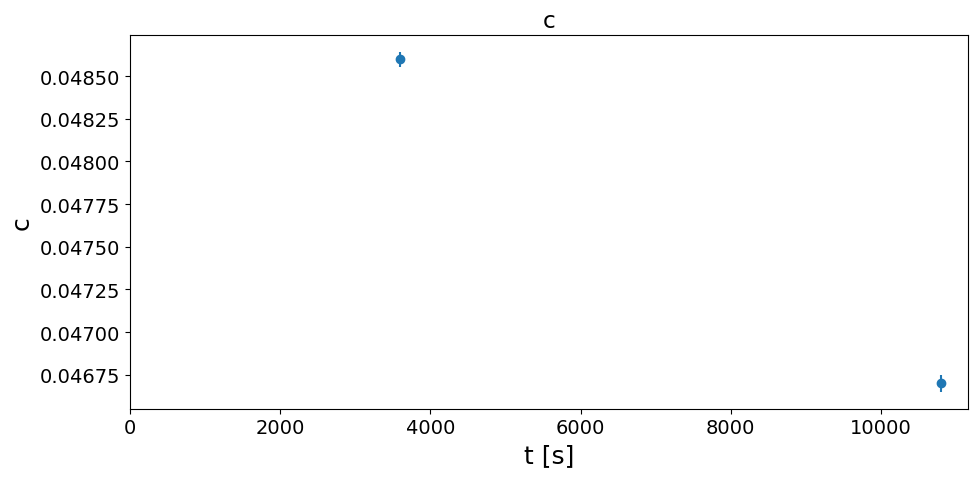

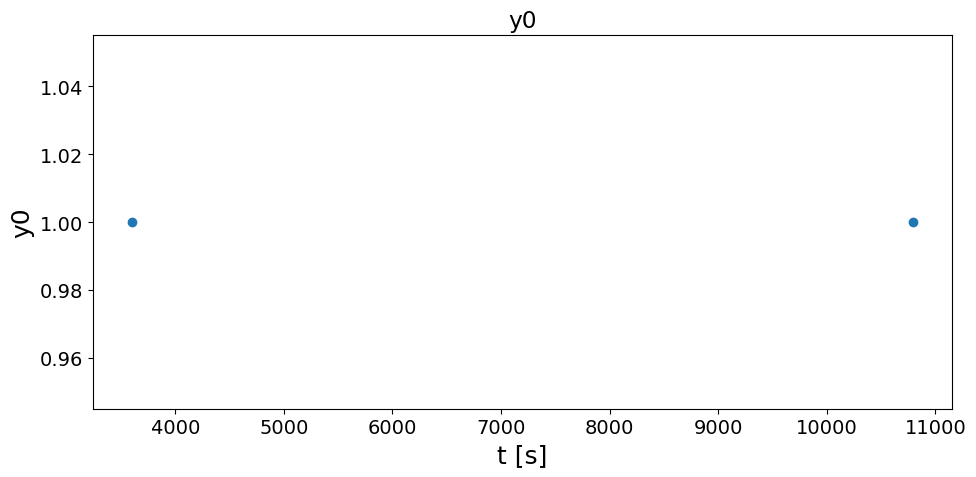

Exception ignored in: <function ResourceTracker.__del__ at 0x7fa746773c40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fd7618bfc40>
Traceback (most recent call last):
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/data/visitor/hc6211/id10-coh/20250527/miniconda3/envs/XPCSenv_test/lib/python3.13/multiprocessing/resource_tracker.py", li

In [ ]:
##################
t1_fit = 0
t2_fit = 1e3
##################

#####################################################
model = lm.Model(decorrelation_f)
params = lm.Parameters()
params.add('tau', value=1000, min=0, max=1e6)
params.add('beta', value=1, min=0, max=2)
params.add('c', value=.02, min=0, max=1)
#params.add('y0', value=1, min=0, max=2)
params.add('y0', value=1., vary=False)
#####################################################
 
plt.figure(figsize=(10,5))
g2_fit = pd.DataFrame(columns=['Q', 'dQ', 'tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
g2_fit.index.name = 't'
for i,k in enumerate(g2.keys()):
    plt.scatter(t_g2[k], g2[k], s=1,  c='C'+str(i), label = str(k)+'s')
    t_mt, g2_mt = XPCS.get_g2mt_fromling2(itime*Lbin, g2[k])
    plt.scatter(t_mt, g2_mt, c='C'+str(i), label=str(k)+'s')

    x = t_g2[k] [(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    y = g2[k][(t1_fit<t_g2[k])*(t_g2[k]<t2_fit)]
    fit = model.fit(y, params, t=x)
    g2_fit.loc[k] = [Q, dq, fit.params['tau'].value, fit.params['beta'].value, fit.params['c'].value, fit.params['y0'].value, fit.params['tau'].stderr, fit.params['beta'].stderr, fit.params['c'].stderr, fit.params['y0'].stderr]

    x = np.arange(np.min(t_g2[k])/2, np.max(t_g2[k])*2, 1e-2)
    y = decorrelation_f(x, *g2_fit.loc[k].values[2:6])
    plt.plot(x, y,)

g2_fit.to_csv(g2fit_folder+'g2fit_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4)+'_Q='+str(Q)+'_dq='+str(dq)+'.csv')

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1, 1.06)
#plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(g2_fit.index, g2_fit.tau,  yerr=g2_fit.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(g2_fit.index, g2_fit.beta,  yerr=g2_fit.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(g2_fit.index, g2_fit.c,  yerr=g2_fit.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.xlim(0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(g2_fit.index, g2_fit.y0,  yerr=g2_fit.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.tight_layout(); plt.show()

### Multi-tau Correlation (TO BE REORDER!!!)

In [ ]:
XPCS.print_Nf_choices(len(scan['fast_timer_period']))

       Nf = 2504444    =>    log2(Nf) = 21.26
----------------------------------------------------
  reduced Nf  dense depth (2^x)  thrown frames %  thrown frames
0      2**21                 20             16.3         407292
1    9*2**18                 17              6.0         145148
2   19*2**17                 16              1.0          14076
3  305*2**13                 12              0.0           5884
4  611*2**12                 11              0.0           1788
----------------------------------------------------


In [ ]:
##### INPUTS #####
Nfi = 0
Nff = 0 +2**21
sparse_depth = 13
dense_depth = 20
##################

G2tmt = XPCS.get_G2tmt_4sparse(e4m_data, sparse_depth, dense_depth, Nfi, Nff, mask=None)
#G2tmt = XPCS.get_G2tmt_4sparse_bypartialloading(RAW_folder, sample_name, Ndataset, Nscan, sparse_depth, dense_depth, Nfi, Nff, mask = load_mask, n_jobs=1)
t_mt, g2_mt, dg2_mt = XPCS.get_g2mt(itime, G2tmt)

Loading frames ...
Done! (elapsed time = 1.5 s)
	 | 2097152 frames X 192980 pixels
	 | sparsity = 4.12e-04
	 | memory usage (sparse.csr_array @ float32) = 1.881 GB
Computing sparse multitau G2t...


100%|██████████| 256/256 [00:40<00:00,  6.38it/s]


Done! (elapsed time = 40.18 s)
Computing dense multitau G2t...


100%|██████████| 7/7 [00:00<00:00, 60.13it/s]

Done! (elapsed time = 0.12 s)


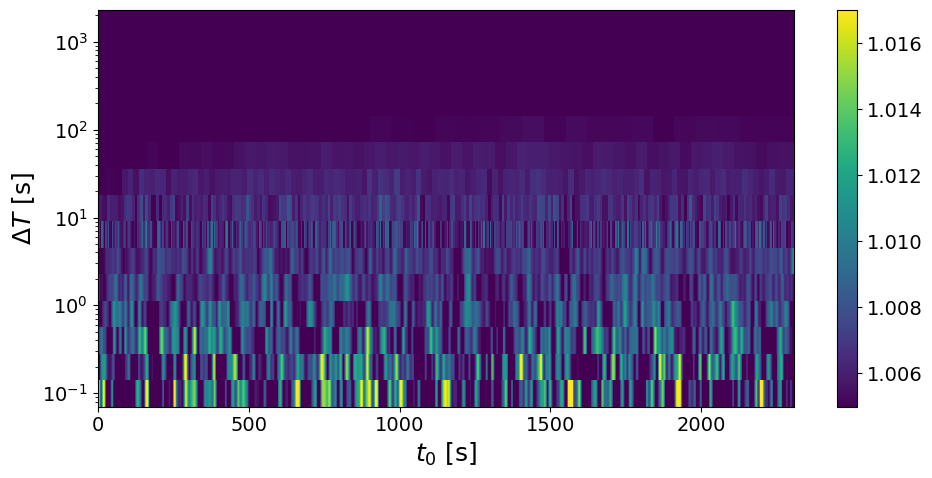

In [ ]:
############################
vmin, vmax = 1.005, 1.017
lower_mt = 6
filter_layer = 12
############################

XPCS.plot_G2tmt(G2tmt, itime, vmin, vmax, yscale='log', lower_mt=lower_mt, filter_layer=filter_layer)

In [ ]:
cut1 = XPCS.cut_G2tmt(itime, G2tmt, tmin=None, tmax=3000)
cut2 = XPCS.cut_G2tmt(itime, G2tmt, tmin=3000, tmax=6000)
cut3 = XPCS.cut_G2tmt(itime, G2tmt, tmin=6000, tmax=15000)
t_mt_1, g2_mt_1, dg2_mt_1 = XPCS.get_g2mt(itime, cut1)
t_mt_2, g2_mt_2, dg2_mt_2 = XPCS.get_g2mt(itime, cut2)
t_mt_3, g2_mt_3, dg2_mt_3 = XPCS.get_g2mt(itime, cut3)

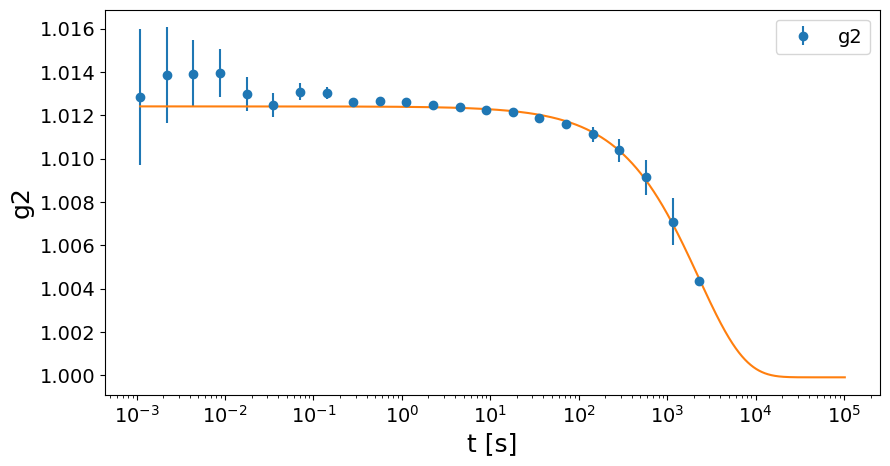

tau = 2278.4462895214124 +/- 980.3358234853137
beta = 0.8327289412512385 +/- 0.0798632634225064
c = 0.012514664192682625 +/- 0.0027602589650978534
y0 = 0.9999000000000001 +/- 0.002718059032489621


In [ ]:
##################
t1_fit = 1
t2_fit = 1e8
##################

plt.figure(figsize=(10,5))
plt.errorbar(t_mt, g2_mt, yerr=dg2_mt, fmt='o', label='g2')
#plt.errorbar(t_mt_1, g2_mt_1, yerr=dg2_mt_1, fmt='o', label='CUT1')
#plt.errorbar(t_mt_2, g2_mt_2, yerr=dg2_mt_2, fmt='o', label='CUT2')
#plt.errorbar(t_mt_3, g2_mt_3, yerr=dg2_mt_3, fmt='o', label='CUT3')


popt, pcov = curve_fit(decorrelation_f, t_mt[(t1_fit<t_mt)*(t_mt<t2_fit)], g2_mt[(t1_fit<t_mt)*(t_mt<t2_fit)], p0=[1000, .8, .04, 1], bounds=([0, 0, 0, .9999], [np.inf, np.inf, np.inf, 1.1]))
x = np.arange(np.min(t_mt), np.max(t_mt)+1e5, 1e-2)
y = decorrelation_f(x, *popt)
plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()


print(f'tau = {popt[0]} +/- {np.sqrt(pcov[0,0])}')
print(f'beta = {popt[1]} +/- {np.sqrt(pcov[1,1])}')
print(f'c = {popt[2]} +/- {np.sqrt(pcov[2,2])}')
print(f'y0 = {popt[3]} +/- {np.sqrt(pcov[3,3])}')
